# SIIM-ACR Pneumothorax Segmentation
> Author: Adrià Carrasquilla Fortes
>
> DLMIA 2022-23

This notebook consists on the implementation of a machine learning solution for the SIIM-ACR Pneumothorax Segmentation challenge. It will introduce what is the goal of the contests, followed by some data exploration, the implementation of the solution and finally it explores the results with some conclusions.

## 1. Introduction
Talk about pneumothorax

## 2. Data Exploration
Show some samples and stuff

In [1]:
# Imports
import os
import sys
import glob
import random

import cv2
import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

Imports for implementation 2

In [2]:
!pip install albumentations > /dev/null
!pip install -U efficientnet==0.0.4
import gc
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split, StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
# from keras.engine.topology import get_source_inputs
# from keras.engine import InputSpec
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras import optimizers
# from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.regularizers import l2
# from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
# from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
    
%matplotlib inline

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet: filename=efficientnet-0.0.4-py3-none-any.whl size=14288 sha256=1d7855db99673a8471aaf887f2301f63bfa7945661076806997b0c59954d1bc7
  Stored in directory: /root/.cache/pip/wheels/e7/36/f8/f808aff9f50374552a83e73bb38e4e6b60285df3779a7d3279
Successfully built efficientnet


In [2]:
## Utilities for easing the data exploration through dicom (.dcm) files.
def print_dcm(sample):
    print()
    pat_name = sample.PatientName
    print("Displaying information for patient", pat_name)
    print("File                :", file_path)
    print()

    print("Id                  :", sample.PatientID)
    print("Age                 :", sample.PatientAge)
    print("Sex                 :", sample.PatientSex)
    print("Modality            :", sample.Modality)
    print("Body Part           :", sample.BodyPartExamined)
    print("View Position       :", sample.ViewPosition)
    print("Image size          : {} x {}".format(sample.Rows, sample.Columns))
    print()
    
def plot_pixel_array(sample, title=None):
    plt.figure(figsize=(8,8))
    plt.imshow(sample.pixel_array, cmap=plt.cm.bone)
    plt.axis("off")
    if title:
        plt.title(title)
    else:
        plt.title(f"{sample.Modality} for patient {sample.PatientID}")
    plt.show()

In order to see how our data looks like, we explore the dicom metadata and the image from 3 random dicom files from the training set.


Displaying information for patient 622f2cd3-7403-45f0-a53d-7d88ba96055b
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.13389.1517875245.104576.dcm

Id                  : 622f2cd3-7403-45f0-a53d-7d88ba96055b
Age                 : 35
Sex                 : M
Modality            : CR
Body Part           : CHEST
View Position       : PA
Image size          : 1024 x 1024



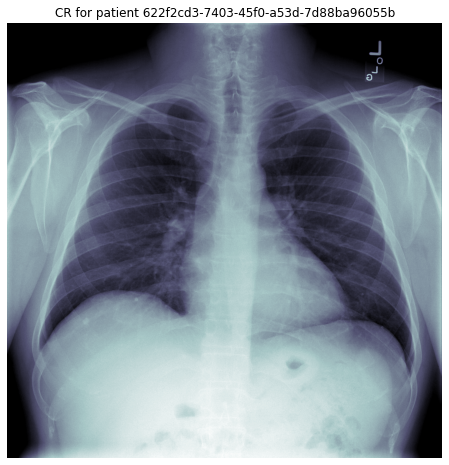


Displaying information for patient 15f05b19-3673-46a4-8a55-1952d4e2b829
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.3340.1517875177.340788.dcm

Id                  : 15f05b19-3673-46a4-8a55-1952d4e2b829
Age                 : 57
Sex                 : F
Modality            : CR
Body Part           : CHEST
View Position       : PA
Image size          : 1024 x 1024



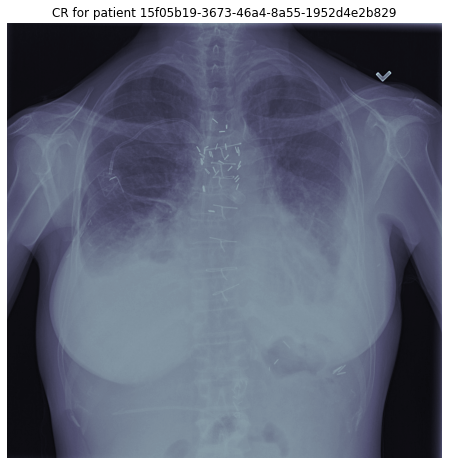


Displaying information for patient b0bc9545-e930-4390-a294-3b256a4c28dc
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.32568.1517875161.247855.dcm

Id                  : b0bc9545-e930-4390-a294-3b256a4c28dc
Age                 : 52
Sex                 : F
Modality            : CR
Body Part           : CHEST
View Position       : AP
Image size          : 1024 x 1024



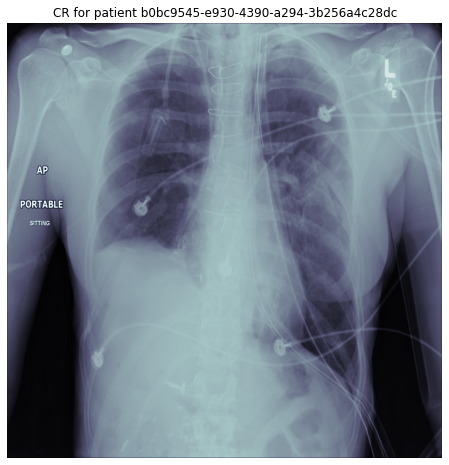

In [3]:
random.seed(1)
samples = random.sample(glob.glob('/kaggle/input/pneumothorax/train/dicom_files/*'), 3)

for file_path in samples:
    sample = pydicom.dcmread(file_path)
    print_dcm(sample)
    plot_pixel_array(sample)

We have just printed a few fields from the dicom metadata fields such as the patient ID, its age and sex. We can also see that all the samples seem to be CR scans of the chest with a size of 1024 by 1024.

We can also observe the is some text or other kind of artifacts (or medical equipment) that is visible in the images and that we bust be aware of during training.

Let's now visualize other samples with their respective masks. For this we will simply use the first n samples from the training dataset csv, so let's explore how this csv also looks like.

In [4]:
train = pd.read_csv("/kaggle/input/pneumothorax/train/train-rle.csv")
train.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


We can see it has two columns. The first one containing the image id that is also the name of input files and the EncodedPixels field. This second one contains a -1 if there is no pneumothorax to be segmented in the image, or the segmentation mask if there is indeed pneumothorax in the sample.

In [5]:
def rle2mask(rle, width, height):
    '''
    RLE to mask conversion as given.
    It inputs the rle (EncodedPixel value) and return the mask value.
    '''
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height).T

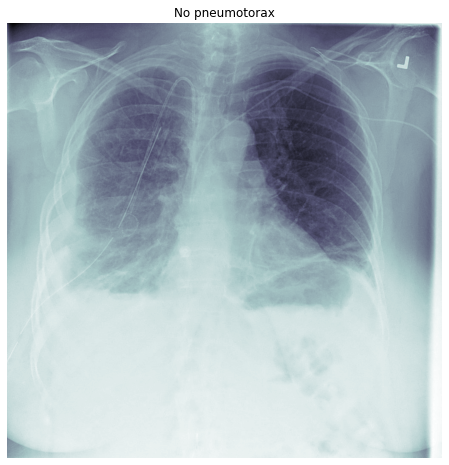

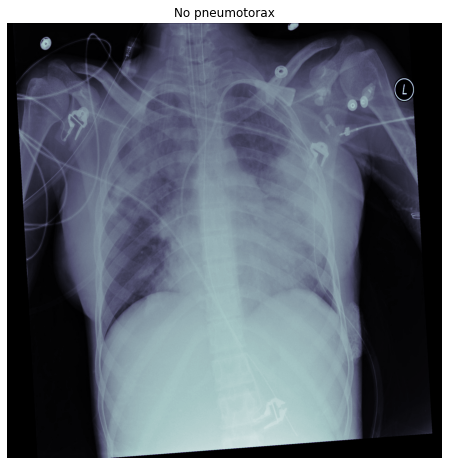

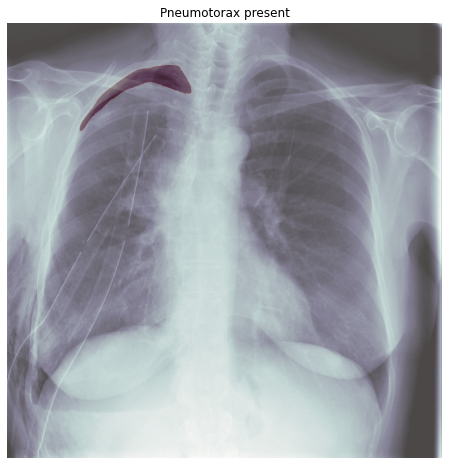

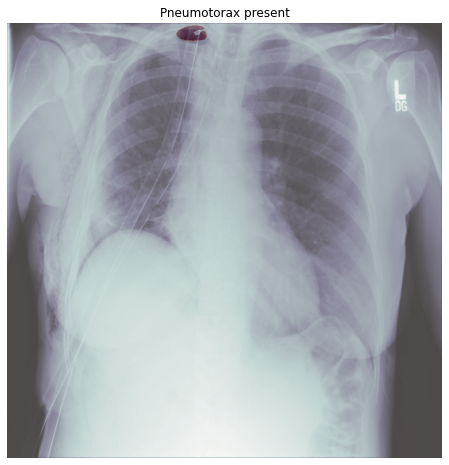

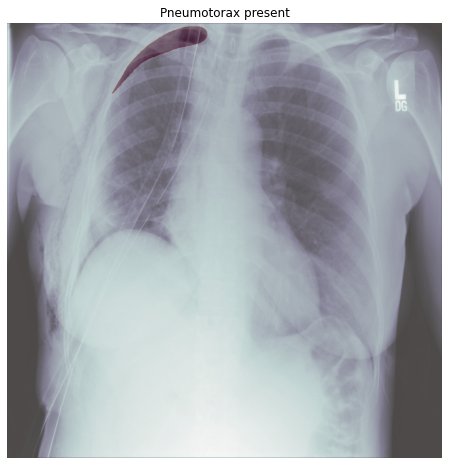

In [6]:
root = "/kaggle/input/pneumothorax/train/dicom_files/"
for i in range(0,5):
    f_id = train["ImageId"][i]
    sample = pydicom.dcmread(f"{root}{f_id}.dcm")
    if train[" EncodedPixels"][i] == ' -1':
        plot_pixel_array(sample, title="No pneumotorax")
    else:
        plt.figure(figsize=(8,8))
        plt.imshow(sample.pixel_array, cmap=plt.cm.bone)
        mask = rle2mask(train[" EncodedPixels"][i][1:], sample.Rows, sample.Columns) * 255
        plt.imshow(mask, alpha=0.3, cmap="Reds")
        plt.axis("off")
        plt.title("Pneumotorax present")
        plt.show()

## 3. Implementation
Describe the solution 

In [7]:
train_files = sorted(glob.glob('/kaggle/input/pneumothorax/train/dicom_files/*'))[:500]
test_files = sorted(glob.glob('/kaggle/input/pneumothorax/test/dicom_files/*'))[:500]
train_df = pd.read_csv('/kaggle/input/pneumothorax/train/train-rle.csv', index_col='ImageId')

In [8]:
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_files), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_files), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm_notebook(enumerate(train_files), total=len(train_files)):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')

Getting train images and masks ... 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


  0%|          | 0/500 [00:00<?, ?it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351 without mask, assuming healthy patient.
Done!


In [14]:
im_height = 256
im_width = 256
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))

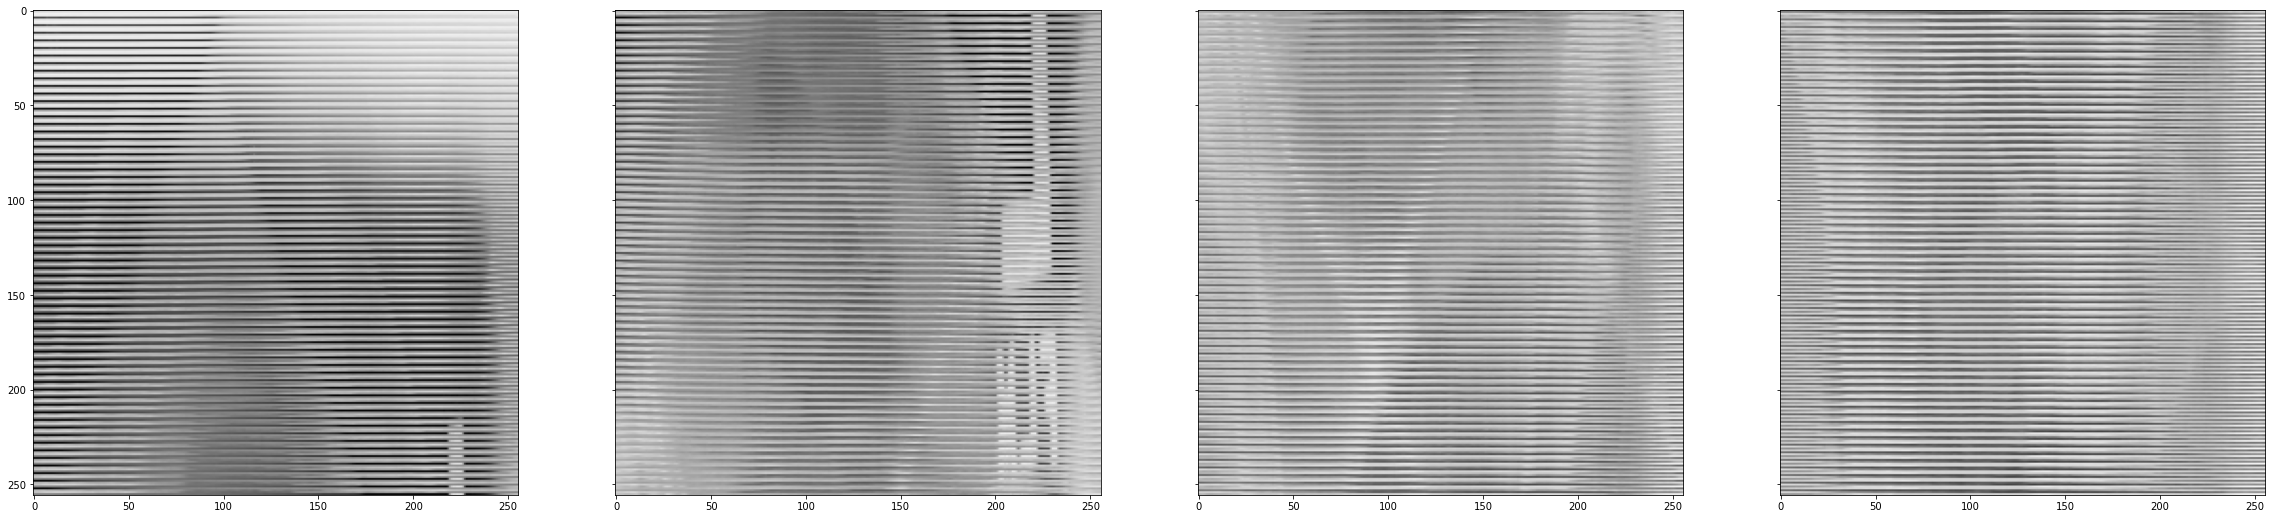

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(40,10))
for q, d in enumerate(X_train[:4]):
    ax[q].imshow(np.squeeze(np.stack((d,)*3, -1)), cmap=plt.cm.bone)

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [17]:
inputs = Input((None, None, im_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
metrics = [] #dice_coef]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
# model.summary()

In [18]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=32, epochs=1)

200/200 [==============================] - 19s 81ms/step - loss: 0.0282 - val_loss: 0.0188


### Implementation 2

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path_list, labels, batch_size=32, 
                 img_size=256, channels=1, shuffle=True):
        self.file_path_list = file_path_list
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.file_path_list)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        file_path_list_temp = [self.file_path_list[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(file_path_list_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.file_path_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, file_path_list_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        y = np.empty((self.batch_size, self.img_size, self.img_size, self.channels))
        
        for idx, file_path in enumerate(file_path_list_temp):
            
            id = file_path.split('/')[-1][:-4]
            rle = self.labels.get(id)
            image = pydicom.read_file(file_path).pixel_array
            image_resized = cv2.resize(image, (self.img_size, self.img_size))
            image_resized = np.array(image_resized, dtype=np.float64)
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            
            # if there is no mask create empty mask
            # notice we are starting of with 1024 because we need to use the rle2mask function
            if rle is None:
                mask = np.zeros((1024, 1024))
            else:
                if len(rle) == 1:
                    mask = rle2mask(rle[0], 1024, 1024).T
                else: 
                    mask = np.zeros((1024, 1024))
                    for r in rle:
                        mask =  mask + rle2mask(r, 1024, 1024).T
                        
            mask_resized = cv2.resize(mask, (self.img_size, self.img_size))
            y[idx,] = np.expand_dims(mask_resized, axis=2)
            
        # normalize 
        X = X / 255
        y = y / 255
            
        return X, y

In [7]:
train_im_path,train_mask_path = '/kaggle/input/pneumothorax/train/images/256/dicom/','/kaggle/input/pneumothorax/train/images/256/mask/'
h,w,batch_size = 256,256,16

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

In [8]:
a = DataGenerator(batch_size=64,shuffle=False)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

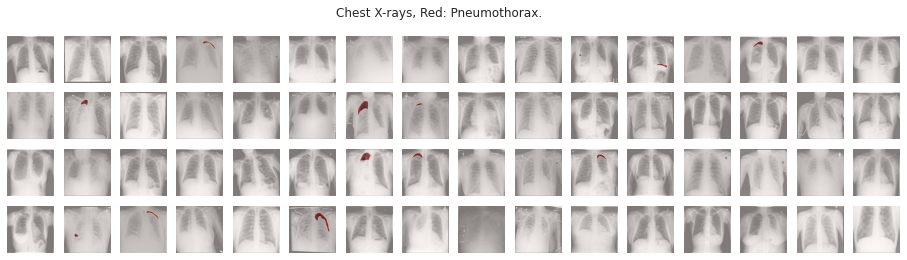

In [9]:
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [41]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.numpy_function(get_iou_vector, [label, pred > 0.5], tf.float64)

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [13]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [17]:
from tensorflow.keras.applications import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    print(deconv3, deconv4_up1, conv3)
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [23]:
def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    #model.name = 'u-xception2'

    return model

In [24]:
K.clear_session()
img_size = 256
# model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)
model = UXception(input_shape=(img_size,img_size,3),dropout_rate=0.5)

In [37]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            #SWA('./keras_swa.model',77),
            #callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [38]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [43]:
[my_iou_metric]
metrics = []
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=metrics)

In [44]:
epochs = 3
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 16
swa = SWA('./keras_swa.model',77)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'
# Generators
training_generator = DataGenerator(img_size=256)
validation_generator = DataGenerator(img_size=256)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,                            
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=2,
                              callbacks=snapshot.get_callbacks())

Epoch 1/80


2022-12-21 13:43:46.630140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


670/670 - 370s - loss: 1.0218 - val_loss: 1.4996
Epoch 2/80
670/670 - 346s - loss: 0.8133 - val_loss: 0.7933
Epoch 3/80


KeyboardInterrupt: 

## 4. Results
Explore results

## 5. Conclusions
write down some conclusions